# **Application of Xgboost for Flood Susceptibility Zonation**

## **Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

## **Read the Data**

In [2]:
training_df = pd.read_csv("D:\Research Works\Flood\Flood_Risk_Zonation_of_Maldah\Datasets\CSVs\Training_Data.csv")
testing_df = pd.read_csv("D:\Research Works\Flood\Flood_Risk_Zonation_of_Maldah\Datasets\CSVs\Testing_Data.csv")

In [3]:
training_df.head()

,Relief_Amplitude,Dist_to_River,TWI,Rainfall,Clay_Content,STI,TRI,TPI,SPI,NDVI,...,Lithology_Fe_Ox_S_Si_Cl,Lithology_S_Si_Cl,Lithology_S_Si_Cl_wi_Cal_Co,Lithology_S_Si_Gr,LULC_Agricultural_Field,LULC_Bare_Ground,LULC_Built_UP_Area,LULC_Natural_Vegetation,LULC_Waterbodies,Flood
0,0.142857,0.518128,0.165104,0.587614,0.785714,0.000000,0.280636,0.580849,0.000000e+00,0.700116,...,0,1,0,0,1,0,0,0,0,1
1,0.000000,0.128572,0.571387,0.344053,0.690476,0.000000,0.000000,0.501084,5.680000e-06,0.437787,...,0,1,0,0,1,0,0,0,0,1
2,0.061224,0.164325,0.149176,0.698571,0.761905,0.000000,0.177382,0.533338,0.000000e+00,0.601291,...,0,1,0,0,1,0,0,0,0,1
3,0.102041,0.433816,0.446274,0.324463,0.714286,0.000881,0.263824,0.460808,3.050000e-05,0.616554,...,0,0,0,0,1,0,0,0,0,1
4,0.122449,0.628029,0.320437,0.359155,0.738095,0.000070,0.327950,0.456793,7.680000e-07,0.572900,...,0,0,0,0,1,0,0,0,0,0


In [4]:
# Drop the geometry columns
training_df.drop("geometry", axis=1, inplace=True)
testing_df.drop("geometry", axis=1, inplace=True)

training_df.columns == testing_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [5]:
training_df.shape

(1582, 33)

In [6]:
# Check for the null values
training_df.isnull().sum().sum()

0

In [7]:
testing_df.isnull().sum().sum()

0

## **Specify the Train Test Data**

In [8]:
X_train, y_train = training_df.drop("Flood", axis=1), training_df["Flood"]
X_test, y_test = testing_df.drop("Flood", axis=1), testing_df["Flood"]

X_train.shape, X_test.shape

((1582, 32), (678, 32))

In [9]:
X_train.head()

,Relief_Amplitude,Dist_to_River,TWI,Rainfall,Clay_Content,STI,TRI,TPI,SPI,NDVI,...,Lithology_Cl_wi_S_Si_Ir_N,Lithology_Fe_Ox_S_Si_Cl,Lithology_S_Si_Cl,Lithology_S_Si_Cl_wi_Cal_Co,Lithology_S_Si_Gr,LULC_Agricultural_Field,LULC_Bare_Ground,LULC_Built_UP_Area,LULC_Natural_Vegetation,LULC_Waterbodies
0,0.142857,0.518128,0.165104,0.587614,0.785714,0.000000,0.280636,0.580849,0.000000e+00,0.700116,...,0,0,1,0,0,1,0,0,0,0
1,0.000000,0.128572,0.571387,0.344053,0.690476,0.000000,0.000000,0.501084,5.680000e-06,0.437787,...,0,0,1,0,0,1,0,0,0,0
2,0.061224,0.164325,0.149176,0.698571,0.761905,0.000000,0.177382,0.533338,0.000000e+00,0.601291,...,0,0,1,0,0,1,0,0,0,0
3,0.102041,0.433816,0.446274,0.324463,0.714286,0.000881,0.263824,0.460808,3.050000e-05,0.616554,...,1,0,0,0,0,1,0,0,0,0
4,0.122449,0.628029,0.320437,0.359155,0.738095,0.000070,0.327950,0.456793,7.680000e-07,0.572900,...,1,0,0,0,0,1,0,0,0,0


In [10]:
# Change the datatype into float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

## **Feature Selection using Information Gain**

In [12]:
# Select the important features
selected_features = ['Dist_to_River', 'TWI', 'Rainfall', 'Clay_Content', 'TRI', 'NDVI',
                     'MFI', 'Elevation', 'MNDWI', 'Drainage_Density', 'Geomorphology_Active_Flood_Plain',
                     'Geomorphology_Older_Alluvial_Plain', 'Geomorphology_Older_Flood_Plain',
                     'Lithology_Cl_wi_S_Si_Ir_N', 'Lithology_Fe_Ox_S_Si_Cl',
                     'Lithology_S_Si_Cl', 'Lithology_S_Si_Cl_wi_Cal_Co',
                     'LULC_Agricultural_Field', 'LULC_Built_UP_Area',
                     'LULC_Natural_Vegetation']

In [13]:
X_train = X_train[selected_features]
X_train

,Dist_to_River,TWI,Rainfall,Clay_Content,TRI,NDVI,MFI,Elevation,MNDWI,Drainage_Density,Geomorphology_Active_Flood_Plain,Geomorphology_Older_Alluvial_Plain,Geomorphology_Older_Flood_Plain,Lithology_Cl_wi_S_Si_Ir_N,Lithology_Fe_Ox_S_Si_Cl,Lithology_S_Si_Cl,Lithology_S_Si_Cl_wi_Cal_Co,LULC_Agricultural_Field,LULC_Built_UP_Area,LULC_Natural_Vegetation
0,0.518128,0.165104,0.587614,0.785714,0.280636,0.700116,0.494337,0.346667,0.409042,0.197955,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.128572,0.571387,0.344053,0.690476,0.000000,0.437787,0.326095,0.120000,0.595915,0.695821,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.164325,0.149176,0.698571,0.761905,0.177382,0.601291,0.628901,0.280000,0.382371,0.492745,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.433816,0.446274,0.324463,0.714286,0.263824,0.616554,0.316538,0.386667,0.307860,0.212729,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.628029,0.320437,0.359155,0.738095,0.327950,0.572900,0.335859,0.573333,0.437553,0.028424,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,0.247812,0.458075,0.339795,0.738095,0.167428,0.734888,0.337946,0.213333,0.430147,0.341095,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1578,0.373099,0.441171,0.752537,0.785714,0.213931,0.543738,0.755592,0.280000,0.279368,0.243732,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1579,0.043243,0.521885,0.472152,0.785714,0.000000,0.680051,0.413672,0.240000,0.483247,0.091759,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1580,0.043243,0.218019,0.160826,0.761905,0.088422,0.757050,0.160709,0.173333,0.509301,0.189769,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [14]:
X_test = X_test[selected_features]
X_test

,Dist_to_River,TWI,Rainfall,Clay_Content,TRI,NDVI,MFI,Elevation,MNDWI,Drainage_Density,Geomorphology_Active_Flood_Plain,Geomorphology_Older_Alluvial_Plain,Geomorphology_Older_Flood_Plain,Lithology_Cl_wi_S_Si_Ir_N,Lithology_Fe_Ox_S_Si_Cl,Lithology_S_Si_Cl,Lithology_S_Si_Cl_wi_Cal_Co,LULC_Agricultural_Field,LULC_Built_UP_Area,LULC_Natural_Vegetation
0,0.017297,0.520829,0.088173,0.666667,0.270604,0.713929,0.088429,0.253333,0.440593,0.190851,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.008649,0.570254,0.871880,0.761905,0.138092,0.395510,0.854243,0.253333,0.250467,0.622337,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.079737,0.170232,0.475129,0.761905,0.237181,0.373748,0.427817,0.320000,0.398804,0.711552,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.017297,0.567649,0.370257,0.690476,0.094671,0.735108,0.395295,0.240000,0.452172,0.368527,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.453789,0.506040,0.605048,0.785714,0.000000,0.459768,0.543641,0.213333,0.572473,0.388870,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,0.085180,0.490869,0.805669,0.000000,0.000000,0.416317,0.724173,0.186667,0.322653,0.906714,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
674,0.250812,0.611297,0.665655,0.785714,0.241167,0.415231,0.620405,0.320000,0.391361,0.336242,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
675,0.449732,0.098939,0.858297,0.761905,0.275839,0.720634,0.886617,0.306667,0.452278,0.356751,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
676,0.519858,0.090232,0.453336,0.714286,0.317311,0.560459,0.432133,0.373333,0.326396,0.303396,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## **Apply Xgboost Classification**

### **Build an Xgboost Model**

In [15]:
from xgboost import XGBClassifier

In [17]:
# Instantiate a XGBClassifier object
xgb = XGBClassifier()

### **Hyperparameter Tuning**

In [18]:
# Define all the hyperparameters for Xgboost Model

# Number of boosting rounds
n_estimators = [25, 50, 100, 150, 200, 300]

# Step size shrinkage
learning_rate = [0.05, 0.1, 0.15, 0.2, 0.3]

# Maximum depth of the trees
max_depth = [2, 4, 6, 8, None]

# Minimum sum of instance weight (hessian) needed in a child
min_child_weight = [1, 3, 5, 7]

# Minimum loss reduction required to make a further partition on a leaf node
gamma = [0.0, 0.1, 0.2, 0.3, 0.4]

# Fraction of features used for fitting the trees
colsample_bytree = [0.3, 0.5, 0.7, 1.0]

# Subsample ratio of the training instance
subsample = [0.3, 0.5, 0.7, 1]

In [31]:
# Define the parameter grid in a dictionary
xgb_param_grid = {"n_estimators": n_estimators,
                  "learning_rate": learning_rate,
                  "max_depth": max_depth,
                  "min_child_weight": min_child_weight,
                  "gamma": gamma,
                  "colsample_bytree": colsample_bytree,
                  "subsample": subsample}
xgb_param_grid

{'n_estimators': [25, 50, 100, 150, 200, 300],
 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
 'max_depth': [2, 4, 6, 8, None],
 'min_child_weight': [1, 3, 5, 7],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
 'subsample': [0.3, 0.5, 0.7, 1]}

In [32]:
from sklearn.model_selection import RandomizedSearchCV

In [33]:
# Apply Randomized Search CV
xgb_grid = RandomizedSearchCV(estimator=xgb,
                              param_distributions=xgb_param_grid,
                              n_iter=1000,
                              scoring="accuracy",
                              n_jobs=-1,
                              cv=5,
                              verbose=1)

In [34]:
# Fit the training data to Randomized Search CV
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7,
                                                             1.0],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.3],
                                        'max_depth': [2, 4, 6, 8, None],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [25, 50, 100, 150, 200,
                                                         300],
                                        'subsample': [0.3, 0.5, 0.7, 1]},
                   scoring='accuracy', verbose=1)

In [35]:
xgb_grid.best_params_

{'subsample': 0.7,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [36]:
# Check the best score
xgb_grid.best_score_

0.8552589545980913

In [37]:
# Build a Xgboost Model with best estimators
Xgb_final = xgb_grid.best_estimator_
Xgb_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## **Accuracy Assessment**

In [38]:
# Predict the test data
y_pred = Xgb_final.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score, classification_report

In [40]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8525073746312685


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       323
           1       0.86      0.86      0.86       355

    accuracy                           0.85       678
   macro avg       0.85      0.85      0.85       678
weighted avg       0.85      0.85      0.85       678



## **Feature Importance**

In [43]:
# Get the feature importance
feature_importance = Xgb_final.feature_importances_

# Convert the feature importance into a pandas series
feature_importance = pd.Series(feature_importance, index=X_train.columns)

# Sort the values in descending order
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance

Geomorphology_Active_Flood_Plain      0.249452
LULC_Agricultural_Field               0.122523
Geomorphology_Older_Alluvial_Plain    0.107497
LULC_Built_UP_Area                    0.098994
LULC_Natural_Vegetation               0.071876
Lithology_Cl_wi_S_Si_Ir_N             0.058660
Geomorphology_Older_Flood_Plain       0.057429
Lithology_S_Si_Cl                     0.042842
Lithology_S_Si_Cl_wi_Cal_Co           0.034968
Elevation                             0.027690
NDVI                                  0.017892
Clay_Content                          0.017759
Rainfall                              0.016794
MFI                                   0.015804
Drainage_Density                      0.012483
TRI                                   0.012228
MNDWI                                 0.012082
Dist_to_River                         0.012047
TWI                                   0.010981
Lithology_Fe_Ox_S_Si_Cl               0.000000
dtype: float32

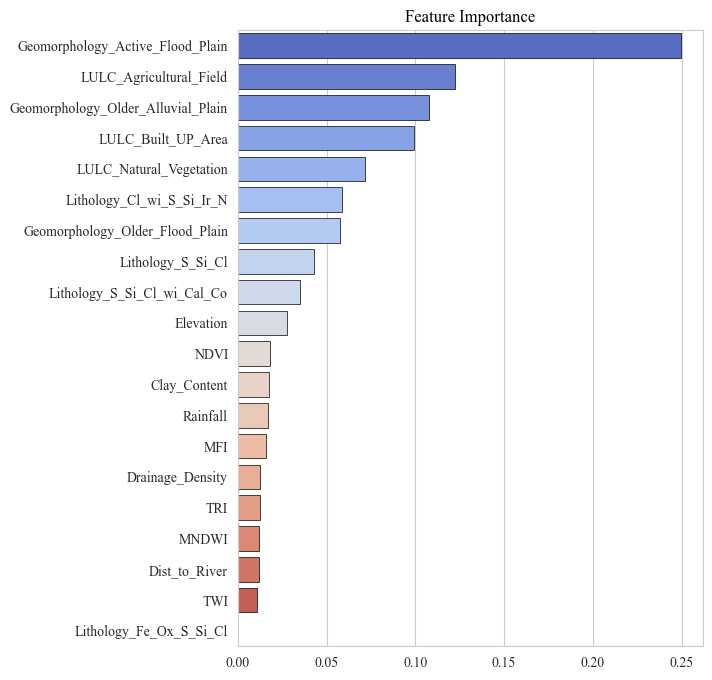

In [50]:
# Plot the feature importance
plt.figure(figsize=(6, 8), dpi=100)

# Define a color palette
color_palette = sns.color_palette(palette="coolwarm", n_colors=len(feature_importance))

sns.barplot(x=feature_importance, y=feature_importance.index, palette=color_palette, 
            edgecolor="black", linewidth=0.5)
plt.title("Feature Importance", fontname="Times New Roman", color="black", fontsize=12)
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")
plt.show()

## **Export the Model**

In [45]:
import pickle

In [46]:
output_folder = "D:\\Coding\\Git Repository\\Research Repo\\Flood\\Flood-Susceptibility-Zonation-of-Maldah\\Model\\"
model_name = "xgb_model.pkl"

In [51]:
# Export the model
# pickle.dump(Xgb_final, file=open(output_folder+model_name, "wb"))